# EE219 Project 3

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
python 3.6  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0   
surprise v0.1  
scikit-surprise v1.0.5


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
import os
from logging.config import fileConfig

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

GET_DATA_FROM_FILES = True

# load data
r_data = pd.read_csv('data/ratings.csv', header=0, usecols=[0, 1, 2])
print(r_data.head())
R = r_data.pivot_table(index='userId', columns='movieId', 
                       values='rating').values
print("(number of users, number of rated movies): ", R.shape)


   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0
(number of users, number of rated movies):  (671, 9066)


#### Question 1

In [2]:
# Question 1
user_count = R.shape[0]
movie_count = R.shape[1]
max_rating_count = user_count*movie_count
rating_count = len(r_data.rating.tolist())
sparsity = rating_count*1.0/max_rating_count
print("Matrix sparsity = %0.4f" % sparsity)

Matrix sparsity = 0.0164


#### Question 2

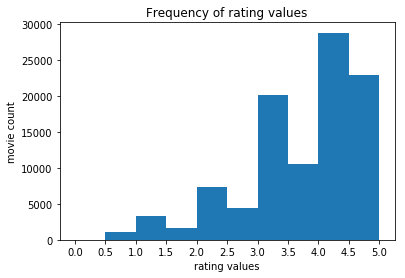

In [3]:
# Question 2
plt.figure()
ax = plt.subplot(111)
ratings = r_data.rating.tolist()
xrange = np.arange(0, 5.5, 0.5)
ax.hist(ratings, bins=xrange)
ax.set_xticks(xrange)
ax.set_title("Frequency of rating values")
ax.set_xlabel("rating values")
ax.set_ylabel("movie count")
plt.show()

#### Question 3

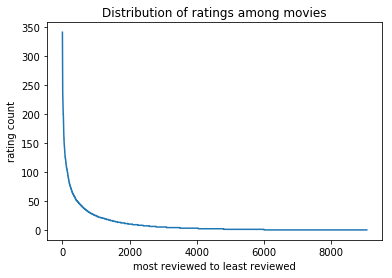

In [4]:
# Question 3
plt.figure()
movie_rating_count = np.count_nonzero(~np.isnan(R), axis=0)
sorted_mrc = sorted(movie_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(movie_rating_count)), sorted_mrc, '-')
ax.set_title("Distribution of ratings among movies")
ax.set_xlabel("most reviewed to least reviewed")
ax.set_ylabel("rating count")
plt.show()

#### Question 4

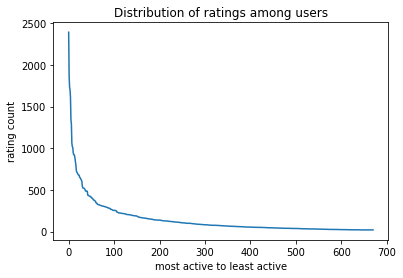

In [5]:
# Question 4
plt.figure()
user_rating_count = np.count_nonzero(~np.isnan(R), axis=1)
sorted_urc = sorted(user_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(user_rating_count)), sorted_urc, '-')
ax.set_title("Distribution of ratings among users")
ax.set_xlabel("most active to least active")
ax.set_ylabel("rating count")
plt.show()

#### Question 5
ToDo: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

#### Question 6

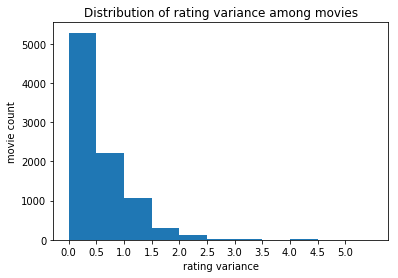

In [6]:
# Question 6
plt.figure()
ax = plt.subplot(111)
movie_var = np.nanvar(R, axis=0)
var_range = np.arange(min(movie_var), max(movie_var)+0.5, 0.5)
ax.hist(movie_var, bins=var_range)
ax.set_xticks(xrange)
ax.set_title("Distribution of rating variance among movies")
ax.set_xlabel("rating variance")
ax.set_ylabel("movie count")
plt.show()

#### Question 7

$I_u$ : Set of item indices for which ratings have been specifed by user $u$  
$I_v$ : Set of item indices for which ratings have been specifed by user $v$  
$\mu_u$ : Mean rating for user $u$ computed using her specifed ratings  
$r_{uk}$ : Rating of user $u$ for item $k$  

$$\mu_u = \frac{\Sigma_{i\in I_{u}} r_{ui}}{\mid I_u \mid}$$

#### Question 8

$I_{u} \cap I_{v}$ represents the indices of movies that are rated by both user $u$ and user $v$. It's possible that this intersection be the empty set ($\emptyset$), given the sparsity of the matrix. It happens when user $u$ has not rated any movie that user $v$ has.

#### Question 9

#### Question 10

In [7]:
import surprise
from surprise import Dataset
from surprise.model_selection import cross_validate
data = Dataset.load_builtin('ml-100k')

k_lst = range(2,101,2)

sim_options = {'name': 'pearson'}
rmse_lst=[]
mae_lst=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_lst.pkl")\
                    and os.path.isfile("./mae_lst.pkl"):
    logging.info("Loading rmse_lst and mae_lst.")
    rmse_lst = pickle.load(open("./rmse_lst.pkl", "rb"))
    mae_lst = pickle.load(open("./mae_lst.pkl", "rb"))
else:
    for k in k_lst:
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_lst.append(np.mean(result['test_rmse']))
        mae_lst.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_lst, open("./rmse_lst.pkl", "wb"))    
    pickle.dump(mae_lst, open("./mae_lst.pkl", "wb"))

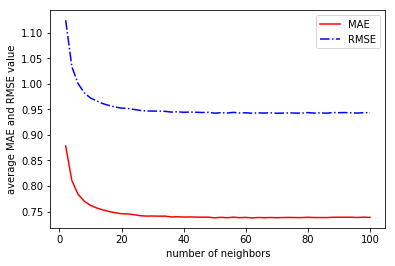

In [8]:
l1, = plt.plot(k_lst, mae_lst, 'r-', label='MAE')
l2, = plt.plot(k_lst, rmse_lst, 'b-.', label='RMSE')
plt.xlabel('number of neighbors')
plt.ylabel('average MAE and RMSE value')
plt.legend(handles=[l1, l2])
plt.show()

#### Question 11

The minimum $k$ is about __12__. MAE converges to __0.74__ and RMSE converges to __0.94__.

#### Question 12,13,14

In [9]:
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold

In [10]:
def trim_popular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter <= 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter <= 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [11]:
def trim_unpopular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter > 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter > 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [12]:
def trim_highvar(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    temp_r = []
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter < 5 or np.var(temp_r) < 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            temp_r = []
            lastm = m
        
        counter += 1
        temp_r.append(r)
        trimmed.append((u, m, r))

    if counter < 5 or np.var(temp_r) < 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [13]:
#test block
ratings_dict = {'userID': [9, 32, 2, 45, 4, 1, 5, 31, 21],
                'itemID': [1, 1, 1, 1, 1, 1, 1, 2, 2],
                'rating': [3.5, 2.5, 4.0, 1, 1, 1, 1, 3.5, 1.0]}
df1 = pd.DataFrame(ratings_dict)
reader1 = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data1 = Dataset.load_from_df(df1[['userID', 'itemID', 'rating']], reader1)

kf1 = KFold(n_splits=2)
for trainset, testset in kf1.split(data1):
    print(trim_popular(testset))

[(4, 1, 1.0), (5, 1, 1.0), (9, 1, 3.5)]
[(1, 1, 1.0), (2, 1, 4.0), (32, 1, 2.5), (45, 1, 1.0)]


In [14]:
kf = KFold(n_splits=10)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(r_data[['userId', 'movieId', 'rating']], reader)

rmse_pop = []
rmse_unpop = []
rmse_highvar = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop.pkl")\
                    and os.path.isfile("./rmse_unpop.pkl")\
                    and os.path.isfile("./rmse_highvar.pkl"):
    logging.info("Loading rmse_pop, rmse_unpop and rmse_highvar.")
    rmse_pop = pickle.load(open("./rmse_pop.pkl", "rb"))
    rmse_unpop = pickle.load(open("./rmse_unpop.pkl", "rb"))
    rmse_highvar = pickle.load(open("./rmse_highvar.pkl", "rb"))
else:
    for k in k_lst:
        rmse_temp_pop = []
        rmse_temp_unpop = []
        rmse_temp_highvar = []
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop = algo.test(trim_popular(testset))
            predictions_unpop = algo.test(trim_unpopular(testset))
            predictions_highvar = algo.test(trim_highvar(testset))
            rmse_temp_pop.append(accuracy.rmse(predictions_pop))
            rmse_temp_unpop.append(accuracy.rmse(predictions_unpop))
            rmse_temp_highvar.append(accuracy.rmse(predictions_highvar))
        rmse_pop.append(np.mean(rmse_temp_pop))
        rmse_unpop.append(np.mean(rmse_temp_unpop))
        rmse_highvar.append(np.mean(rmse_temp_highvar))

    pickle.dump(rmse_pop, open("./rmse_pop.pkl", "wb"))    
    pickle.dump(rmse_unpop, open("./rmse_unpop.pkl", "wb"))
    pickle.dump(rmse_highvar, open("./rmse_highvar.pkl", "wb"))

print(rmse_pop[:5])

[1.0474940413149139, 0.95481980124888055, 0.92194934099151138, 0.90665093687839526, 0.89817706028640032]


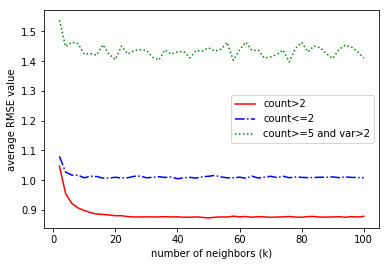

In [15]:
l1, = plt.plot(k_lst, rmse_pop, 'r-', label='count>2')
l2, = plt.plot(k_lst, rmse_unpop, 'b-.', label='count<=2')
l3, = plt.plot(k_lst, rmse_highvar, 'g:', label='count>=5 and var>2')
plt.xlabel('number of neighbors (k)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()

#### Question 15

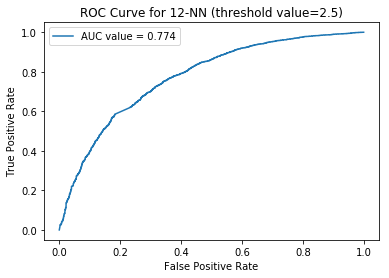

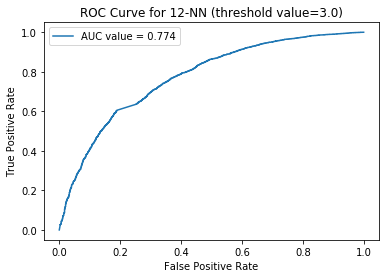

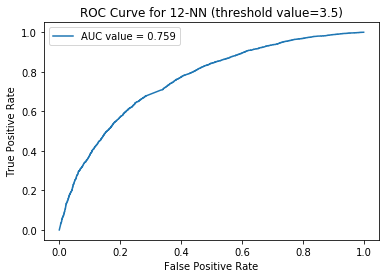

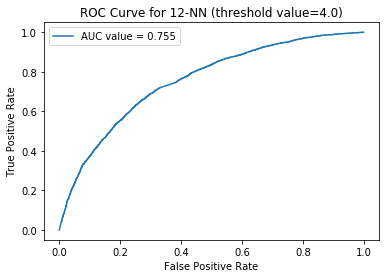

In [16]:
from sklearn import metrics
from surprise.model_selection import train_test_split
mink=12
thresholdlist = [2.5, 3, 3.5, 4]

pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q15.pkl"):
    logging.info("Loading pred_q15.")
    pred = pickle.load(open("./pred_q15.pkl", "rb"))
else:
    algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=mink, sim_options=sim_options)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred = algo.test(testset)
    pickle.dump(pred, open("./pred_q15.pkl", "wb"))
        
for ths in thresholdlist:
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 12-NN (threshold value=%.1f)' % ths)
    plt.legend()
    plt.show()

#### Question 17

In [17]:
from surprise import NMF
k_nnmf = range(2,51,2)

rmse_nnmf=[]
mae_nnmf=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_nnmf.pkl")\
                    and os.path.isfile("./mae_nnmf.pkl"):
    logging.info("Loading rmse_nnmf and mae_nnmf.")
    rmse_nnmf = pickle.load(open("./rmse_nnmf.pkl", "rb"))
    mae_nnmf = pickle.load(open("./mae_nnmf.pkl", "rb"))
else:
    for k in k_nnmf:
        algo = NMF(n_factors=k)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_nnmf.append(np.mean(result['test_rmse']))
        mae_nnmf.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_nnmf, open("./rmse_nnmf.pkl", "wb"))    
    pickle.dump(mae_nnmf, open("./mae_nnmf.pkl", "wb"))

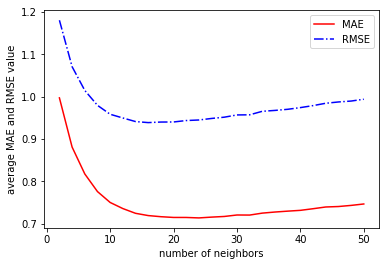

In [18]:
l1, = plt.plot(k_nnmf, mae_nnmf, 'r-', label='MAE')
l2, = plt.plot(k_nnmf, rmse_nnmf, 'b-.', label='RMSE')
plt.xlabel('number of neighbors')
plt.ylabel('average MAE and RMSE value')
plt.legend(handles=[l1, l2])
plt.show()

#### Question 18

In [27]:
print ('the value of k that gives the minimum average RMSE')
print (k_nnmf[np.argsort(rmse_nnmf)[0]])
print ('minimum average RMSE:')
print (np.sort(rmse_nnmf)[0])

the value of k that gives the minimum average RMSE
16
minimum average RMSE:
0.93883589244


In [28]:
print ('the value of k that gives the minimum average MAE :')
print (k_nnmf[np.argsort(mae_nnmf)[0]])
print ('minimum average MAE:')
print (np.sort(mae_nnmf)[0])

the value of k that gives the minimum average MAE :
24
minimum average MAE:
0.713795966474


#### Question 19,20,21

In [29]:
kf = KFold(n_splits=10)

rmse_pop_nnmf = []
rmse_unpop_nnmf = []
rmse_highvar_nnmf = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop_nnmf.pkl")\
                    and os.path.isfile("./rmse_unpop_nnmf.pkl")\
                    and os.path.isfile("./rmse_highvar_nnmf.pkl"):
    logging.info("Loading rmse_pop_nnmf, rmse_unpop_nnmf and rmse_highvar_nnmf.")
    rmse_pop_nnmf = pickle.load(open("./rmse_pop_nnmf.pkl", "rb"))
    rmse_unpop_nnmf = pickle.load(open("./rmse_unpop_nnmf.pkl", "rb"))
    rmse_highvar_nnmf = pickle.load(open("./rmse_highvar_nnmf.pkl", "rb"))
else:
    for k in k_nnmf:
        rmse_temp_pop_nnmf = []
        rmse_temp_unpop_nnmf = []
        rmse_temp_highvar_nnmf = []
        algo = NMF(n_factors=k)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop_nnmf = algo.test(trim_popular(testset))
            predictions_unpop_nnmf = algo.test(trim_unpopular(testset))
            predictions_highvar_nnmf = algo.test(trim_highvar(testset))
            rmse_temp_pop_nnmf.append(accuracy.rmse(predictions_pop_nnmf))
            rmse_temp_unpop_nnmf.append(accuracy.rmse(predictions_unpop_nnmf))
            rmse_temp_highvar_nnmf.append(accuracy.rmse(predictions_highvar_nnmf))
        rmse_pop_nnmf.append(np.mean(rmse_temp_pop_nnmf))
        rmse_unpop_nnmf.append(np.mean(rmse_temp_unpop_nnmf))
        rmse_highvar_nnmf.append(np.mean(rmse_temp_highvar_nnmf))

    pickle.dump(rmse_pop_nnmf, open("./rmse_pop_nnmf.pkl", "wb"))    
    pickle.dump(rmse_unpop_nnmf, open("./rmse_unpop_nnmf.pkl", "wb"))
    pickle.dump(rmse_highvar_nnmf, open("./rmse_highvar_nnmf.pkl", "wb"))

print(rmse_pop_nnmf[:5])

RMSE: 1.1733
RMSE: 1.2172
RMSE: 1.5510
RMSE: 1.1728
RMSE: 1.2169
RMSE: 1.5130
RMSE: 1.1570
RMSE: 1.2171
RMSE: 1.5235
RMSE: 1.1756
RMSE: 1.1865
RMSE: 1.5147
RMSE: 1.1647
RMSE: 1.1952
RMSE: 1.4540
RMSE: 1.1556
RMSE: 1.2271
RMSE: 1.5310
RMSE: 1.1553
RMSE: 1.2017
RMSE: 1.3844
RMSE: 1.1687
RMSE: 1.2255
RMSE: 1.6493
RMSE: 1.1781
RMSE: 1.2065
RMSE: 1.5843
RMSE: 1.1714
RMSE: 1.2124
RMSE: 1.4846
RMSE: 1.0355
RMSE: 1.1442
RMSE: 1.4048
RMSE: 1.0434
RMSE: 1.1387
RMSE: 1.4737
RMSE: 1.0315
RMSE: 1.1361
RMSE: 1.4355
RMSE: 1.0331
RMSE: 1.1389
RMSE: 1.4550
RMSE: 1.0414
RMSE: 1.1410
RMSE: 1.4312
RMSE: 1.0369
RMSE: 1.1360
RMSE: 1.5291
RMSE: 1.0338
RMSE: 1.1249
RMSE: 1.3655
RMSE: 1.0355
RMSE: 1.1283
RMSE: 1.4999
RMSE: 1.0340
RMSE: 1.1567
RMSE: 1.4758
RMSE: 1.0549
RMSE: 1.1368
RMSE: 1.4573
RMSE: 0.9664
RMSE: 1.0910
RMSE: 1.4837
RMSE: 0.9808
RMSE: 1.1166
RMSE: 1.4412
RMSE: 0.9584
RMSE: 1.1045
RMSE: 1.4424
RMSE: 0.9712
RMSE: 1.0844
RMSE: 1.4397
RMSE: 0.9715
RMSE: 1.0971
RMSE: 1.3893
RMSE: 0.9824
RMSE: 1.1048

RMSE: 0.9676
RMSE: 1.0614
RMSE: 1.6747
RMSE: 0.9541
RMSE: 1.0695
RMSE: 1.5092
RMSE: 0.9462
RMSE: 1.0292
RMSE: 1.4391
RMSE: 0.9586
RMSE: 1.0697
RMSE: 1.4586
RMSE: 0.9531
RMSE: 1.0633
RMSE: 1.5567
RMSE: 0.9590
RMSE: 1.0462
RMSE: 1.4955
RMSE: 0.9245
RMSE: 1.0474
RMSE: 1.4834
RMSE: 0.9571
RMSE: 1.0564
RMSE: 1.6101
RMSE: 0.9614
RMSE: 1.0427
RMSE: 1.5400
RMSE: 0.9597
RMSE: 1.0528
RMSE: 1.5900
RMSE: 0.9663
RMSE: 1.0607
RMSE: 1.5482
RMSE: 0.9385
RMSE: 1.0685
RMSE: 1.6001
RMSE: 0.9520
RMSE: 1.0554
RMSE: 1.6475
RMSE: 0.9779
RMSE: 1.0575
RMSE: 1.4774
RMSE: 0.9382
RMSE: 1.0767
RMSE: 1.4919
RMSE: 0.9612
RMSE: 1.0458
RMSE: 1.5712
RMSE: 0.9364
RMSE: 1.0781
RMSE: 1.5000
RMSE: 0.9483
RMSE: 1.0628
RMSE: 1.5454
RMSE: 0.9494
RMSE: 1.0229
RMSE: 1.4247
RMSE: 0.9442
RMSE: 1.0452
RMSE: 1.3730
RMSE: 0.9676
RMSE: 1.0492
RMSE: 1.5854
RMSE: 0.9675
RMSE: 1.0618
RMSE: 1.5414
RMSE: 0.9768
RMSE: 1.0638
RMSE: 1.4940
RMSE: 0.9705
RMSE: 1.0292
RMSE: 1.5235
RMSE: 0.9496
RMSE: 1.0748
RMSE: 1.5146
RMSE: 0.9402
RMSE: 1.0666

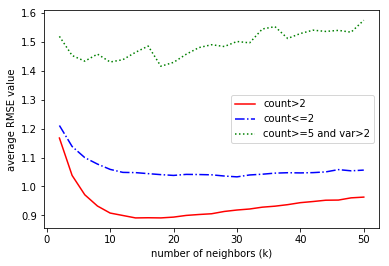

In [30]:
l1, = plt.plot(k_nnmf, rmse_pop_nnmf, 'r-', label='count>2')
l2, = plt.plot(k_nnmf, rmse_unpop_nnmf, 'b-.', label='count<=2')
l3, = plt.plot(k_nnmf, rmse_highvar_nnmf, 'g:', label='count>=5 and var>2')
plt.xlabel('number of neighbors (k)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()

#### Question 22

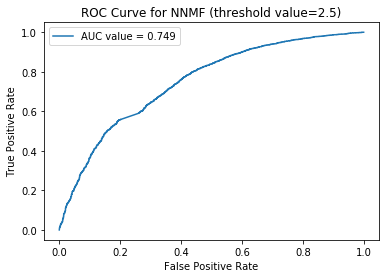

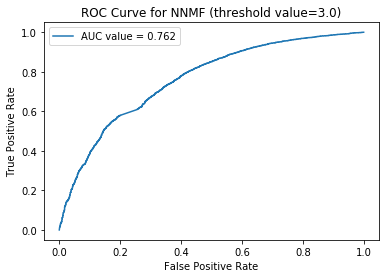

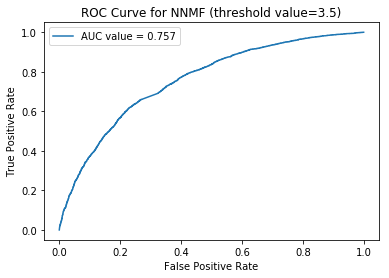

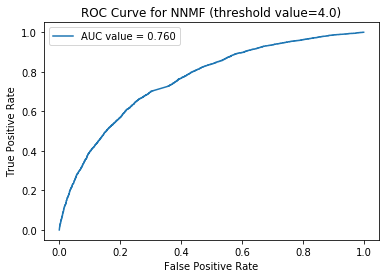

In [32]:
from sklearn import metrics
from surprise.model_selection import train_test_split
# use optimal number of latent factors that minimize RMSE
opt_lfactor=16
thresholdlist = [2.5, 3, 3.5, 4]

pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q22.pkl"):
    logging.info("Loading pred_q22.")
    pred = pickle.load(open("./pred_q22.pkl", "rb"))
else:
    algo = NMF(n_factors=opt_lfactor)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred = algo.test(testset)
    pickle.dump(pred, open("./pred_q22.pkl", "wb"))
        
for ths in thresholdlist:
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for NNMF (threshold value=%.1f)' % ths)
    plt.legend()
    plt.show()

#### Question 23

In [ ]:
k_q23=20
algo = NMF(n_factors=k_q23)